# Import Library

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Read & Analyze Data

In [2]:
file_path = 'training_data.csv'
df = pd.read_csv(file_path)
df.head()

,size (square feet),number of bedrooms,price ($)
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


- Comment: ...

In [4]:
df.describe()

,size (square feet),number of bedrooms,price ($)
count,47.000000,47.000000,47.000000
mean,2000.680851,3.170213,340412.659574
std,794.702354,0.760982,125039.899586
min,852.000000,1.000000,169900.000000
25%,1432.000000,3.000000,249900.000000
50%,1888.000000,3.000000,299900.000000
75%,2269.000000,4.000000,384450.000000
max,4478.000000,5.000000,699900.000000


- Comment: ...

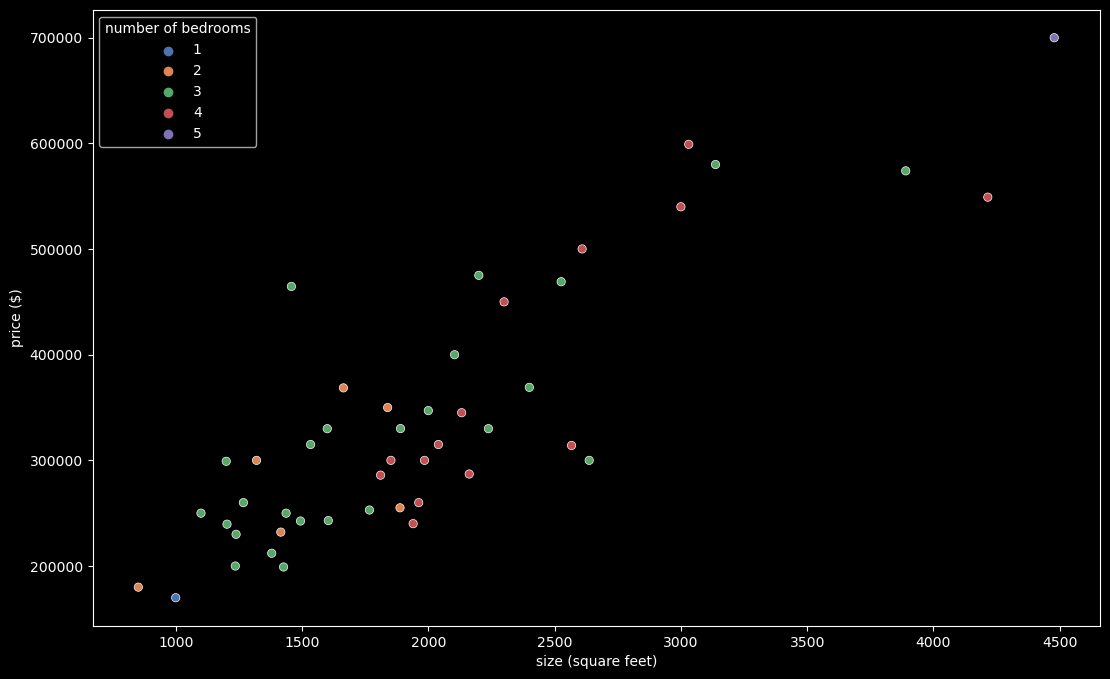

In [5]:
plt.figure(figsize=(13,8))
ax = sns.scatterplot(data=df, x='size (square feet)', y='price ($)', 
                     hue='number of bedrooms', palette='deep')
plt.show()

- Comment: ...

# Helper Functions

In [7]:
def standardize_train_set(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

In [8]:
def standardize_test_set(X, mu, sigma):
    X_norm = (X - mu) / sigma
    return X_norm

In [10]:
class LinearRegression:
    def __init__(self, alpha=0.001, iters=1000, verbose=False):
        self.alpha = alpha
        self.iters = iters
        self.verbose = verbose
        self.theta = None
    
    def calculate_absolute_error(self, X, y, theta):
        error = np.abs(np.dot(X, theta) - y)
        return np.mean(error)
    
    def gradient(self, X, y, theta):
        m = len(y)
        h_theta = np.dot(X, theta)
        loss = h_theta - y
        dJ = np.dot(X.T, loss) / m
        J = np.sum((loss ** 2) / (2*m))
        return (J, dJ)
    
    def gradient_descent(self, X, y):
        X = np.c_[np.ones(len(X),dtype='int64'), X]
        theta = np.zeros(X.shape[1])
        print(f'The total of training sample: {len(y)}')
        for i in range(self.iters):
            J, dJ = self.gradient(X, y, theta)
            theta -= self.alpha * dJ
            if self.verbose:
                print(f'Iter {i + 1}, loss = {self.calculate_absolute_error(X, y, theta)}')
        return theta
    
    def fit(self, X, y):
        self.theta = self.gradient_descent(X, y)
    
    def predict(self, X):
        X = np.c_[np.ones(len(X),dtype='int64'), X]
        return np.dot(X, self.theta)

# Main Function

## Train Model

In [11]:
with open('config.json',) as f:
    configs = json.load(f)

X = df[['size (square feet)', 'number of bedrooms']].values
y = df['price ($)'].values

X, mu, sigma = standardize_train_set(X)
model = LinearRegression(alpha=configs['alpha'], iters=configs['iters'], verbose=False)
model.fit(X, y)

The total of training sample: 47


## Visualize Model

In [12]:
x_surf, y_surf = np.meshgrid(np.linspace(df['size (square feet)'].min(), df['size (square feet)'].max()),
                 np.linspace(df['number of bedrooms'].min(), df['number of bedrooms'].max()))

surf_df = pd.DataFrame({'size (square feet)': x_surf.ravel(), 'number of bedrooms': y_surf.ravel()})
predicted = model.predict(standardize_test_set(surf_df.values, mu, sigma))

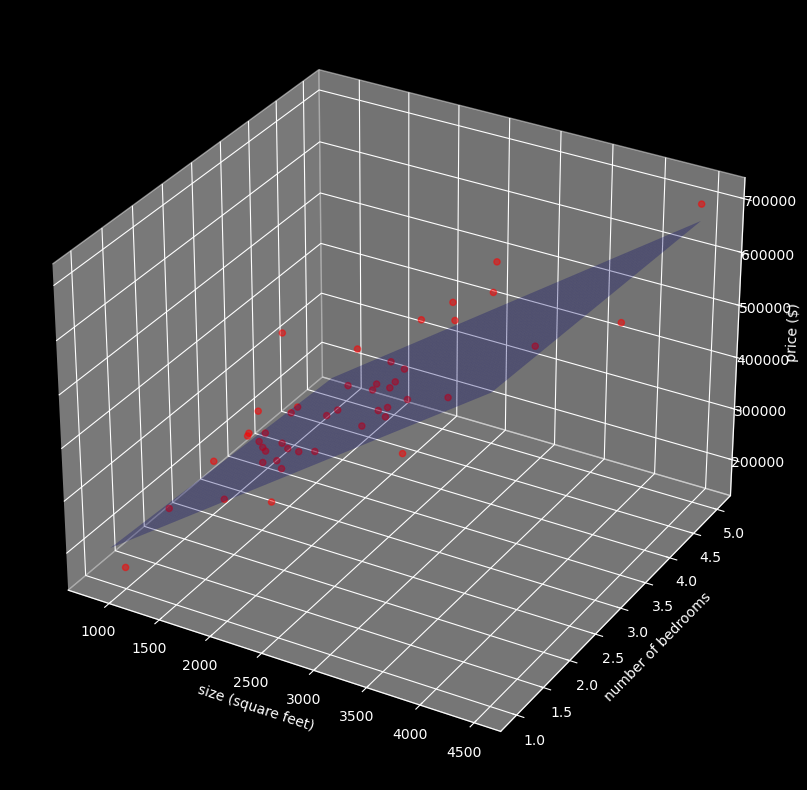

In [13]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['size (square feet)'], df['number of bedrooms']
           ,df['price ($)'], c='red', marker='o', alpha=0.5)
ax.plot_surface(x_surf, y_surf, predicted.reshape(x_surf.shape), color='b', alpha=0.3)

ax.set_xlabel('size (square feet)')
ax.set_ylabel('number of bedrooms')
ax.set_zlabel('price ($)')
plt.show()

- Comment: ...

## Predict Sample

In [14]:
sample = [1650, 3]
X_sample = standardize_test_set(np.array(sample).reshape(1, -1), mu, sigma)
y_predict = model.predict(X_sample)
print(f'House price expected is {round(y_predict[0])}$')

House price expected is 293222$


## Save Results

In [15]:
with open('model.json', 'w') as f:
    json.dump({'theta': model.theta.tolist()}, f)

with open('price.json', 'w') as f:
    result = {
        'size (square feet)': sample[0],
        'number of bedrooms': sample[1],
        'price ($)': round(y_predict[0])
    }
    json.dump(result, f)